In [1]:
# sph related imports
from sph import *
# neural network rlated imports
from torch.optim import Adam
from rbfConv import *
from torch_geometric.loader import DataLoader
from trainingHelper import *
# plotting/UI related imports
from plotting import *
import matplotlib as mpl
plt.style.use('dark_background')
cmap = mpl.colormaps['viridis']
from tqdm.notebook import trange, tqdm
from IPython.display import display, Latex
%matplotlib notebook

# Initial particle density sampling
First we setup the initial distribution of the particles. This is done by defining a PDF (probability density function) which is later used to sample particles such that the resulting density field is equal to the PDF.

Note that to be useful the pdf should always be greater than 0, e.g., it may b useful to shift a pdf you want to sample by a constant factor.

Different PDFs are included here and you should paste the one you want into the field below to use it:

### Sinusoidal Sampling
This is a simple sampling with 4 peaks in the $[-1,1]$ domain. This pdf is shifted by 2 with an intensity of 1 on the sinusoidal wave, i.e., the minimum density is 1 and the maximum density is 3.
```python
pdf = lambda x: np.sin(x * np.pi * 4) + 2
```
### Low Frequency Sinusoidal Sampling
This sinusoidal sampling is of a lower frequency, i.e. there is only a single peak in the domain $[-1,1]$ but this is mostly to show an alternative way to define a pdf by using linear interpolation of an arbitrary set of datapoints.
```python
noise = 2 + np.sin(np.linspace(-np.pi, np.pi, numParticles))
pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)
```
### Square profile
This profile has a peak over $[-\frac{1}{3},\frac{1}{3}]$ where the density is at 2 and 1 everywhere else. This is useful to create a single well defined wave. 
```python
def pdf(x):
    out = np.array(np.ones_like(x) * 2)
    out[np.abs(x) > 1/3] = 1
    return out
```
### Sawtooth profile
This profile creates a discontinuous profile where the sampled density changes from $2$ to $1$ at $x=0$ instantly and linearly ramps between these valus, creating a sawtooth profile.
```python
def pdf(x):
    x = np.array(x)
    out = np.array(np.ones_like(x))
    out[x > 0] = x[x>0] + 0
    out[x < 0] = x[x<0] + 2
    return out + 1
```
### Sharp Sawtooth profile
This profile has a discontinuity at $x=-1$ where the sampled density changes from $2$ to $0$. This 0 density is interesting but should be avoided due to the sampling we use.
```python
pdf = lambda x: 1 + x
```
### Triangular profile
This profile has a peak at $x=0$ with a density of $2$ and linarly ramps to $1$ at the edges of the domain
```python
pdf = lambda x: np.abs(x) + 1
```
### Gaussian profile
This profile is a smoothed variant of th above, change the standard deviation (the $8$) to change how broad the profile is.
```python
pdf = lambda x: 1 + np.exp(-(x * 8)**2) * 2
```
### Uniform profile
This profile is mostly useful for debugging as nothing should happen in this case.
```python
pdf = lambda x: np.ones_like(np.array(x))
```
### Random profile
This profile uses a periodic noise generation, using Perlin noise, to create an octav noise that can be used to generate a lot of different samplings with high frequency components that are still somewhat _smooth_
```python
noise  = 2 + generate1DPeriodicNoise(numSamples = numParticles, r = 0.75, freq = 1, octaves = 4, plot = False, seed = 1234) * 0.25
pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)
```

In [2]:
numParticles = 2048 # Modify th number of desird particles here, this value is defined here to ensure that the linar sampling for some pdfs is accurate.
pdf = lambda x: np.sin(x * np.pi * 4) + 2

# Setup of simulation parameters

Before running the simulation we need to setup some necessary physical parameters:

Parameter | Default | Meaning
---|---|---
minDomain | -1 | The minimum extent of the simulation domain, should be left at -1
maxDomain | 1  | The maximum extent of the simulation domain, should be left at -1
baseArea | 2 / numParticles * 2 | The area (or length) represented by a single particle set based on the simulation domain size and particle count
particleSupport | particlRadius * 8. | The support radius, reducing this value makes the simulations sharper but also less stable so change with caution
xsphConstant | 0.0 | Diffusion coefficient for the XSPH velocity diffusion term. Used as an artificial viscosity but superceeded by the dynamic viscosity
diffusionAlpha | 1.0 | Diffusion coefficient for a standard SPH velocity diffusion, based on Price 2010: https://arxiv.org/pdf/1012.1885.pdf
diffusionBeta | 2.0 | Diffusion coefficient for a standard SPH velocity diffusion, based on Price 2010: https://arxiv.org/pdf/1012.1885.pdf
c0 | 10 | Speed of sound, used for a standard SPH velocity diffusion, based on Price 2010: https://arxiv.org/pdf/1012.1885.pdf
kappa | 10 | Coefficient for the ideal gas EOS
restDensity | 1000 | Coefficient for the ideal gas EOS
dt | 1e-3 | Fixed timestep used for the simulation

Additionally some further parameters need setting up:

Parameter | Default | Meaning
---|---|---
timesteps | 2048 | Number of timesteps that should be simulated
device | 'cuda' | Set to 'cuda' to run on an nvidia GPU and 'cpu' to run in a multithreaded CPU mode.
dtyp | torch.float32 | default numerical precision, should be set to torch.float32 if using GPUs or other accelerators due to their limited FP32 performance.

In [3]:
# simulation parameters
minDomain = -1 # minimum domain, leave at -1 for the most part
maxDomain = 1 # maximum domain, leave at 1 for the most part
# change base area to change initial starting density
baseArea = 2 / numParticles * 2
particleRadius = baseArea / 2.0
# change particle support to make simulation more/less smooth
particleSupport = particleRadius * 8.
# SPH parameters
xsphConstant = 0.0
diffusionAlpha = 1. # kinematic viscosity coefficient
diffusionBeta = 2.
kappa = 10 # EOS kappa term
restDensity = 1000 # EOS rest density term
dt = 1e-3 # fixed global timestep
c0 = 10 # speed of sound used in kinematic viscosity

timesteps = 2048 # timesteps to be simulated
# display(Latex(f'Estimated kinematic diffusion $\\mu\\approx\\frac{{1}}{{2(d+2)}}\\alpha c_s h = \\frac{{1}}{{2(1+2)}} \\cdot {diffusionAlpha} \\cdot {c0} \\cdot {particleSupport:4.2e} = {1/6 * diffusionAlpha * c0 * particleSupport:4.2e}$'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64 if device == 'cpu' else torch.float32
# print('Running on ', device, 'using type', dtype)

## Initialization of the simulation

<IPython.core.display.Javascript object>


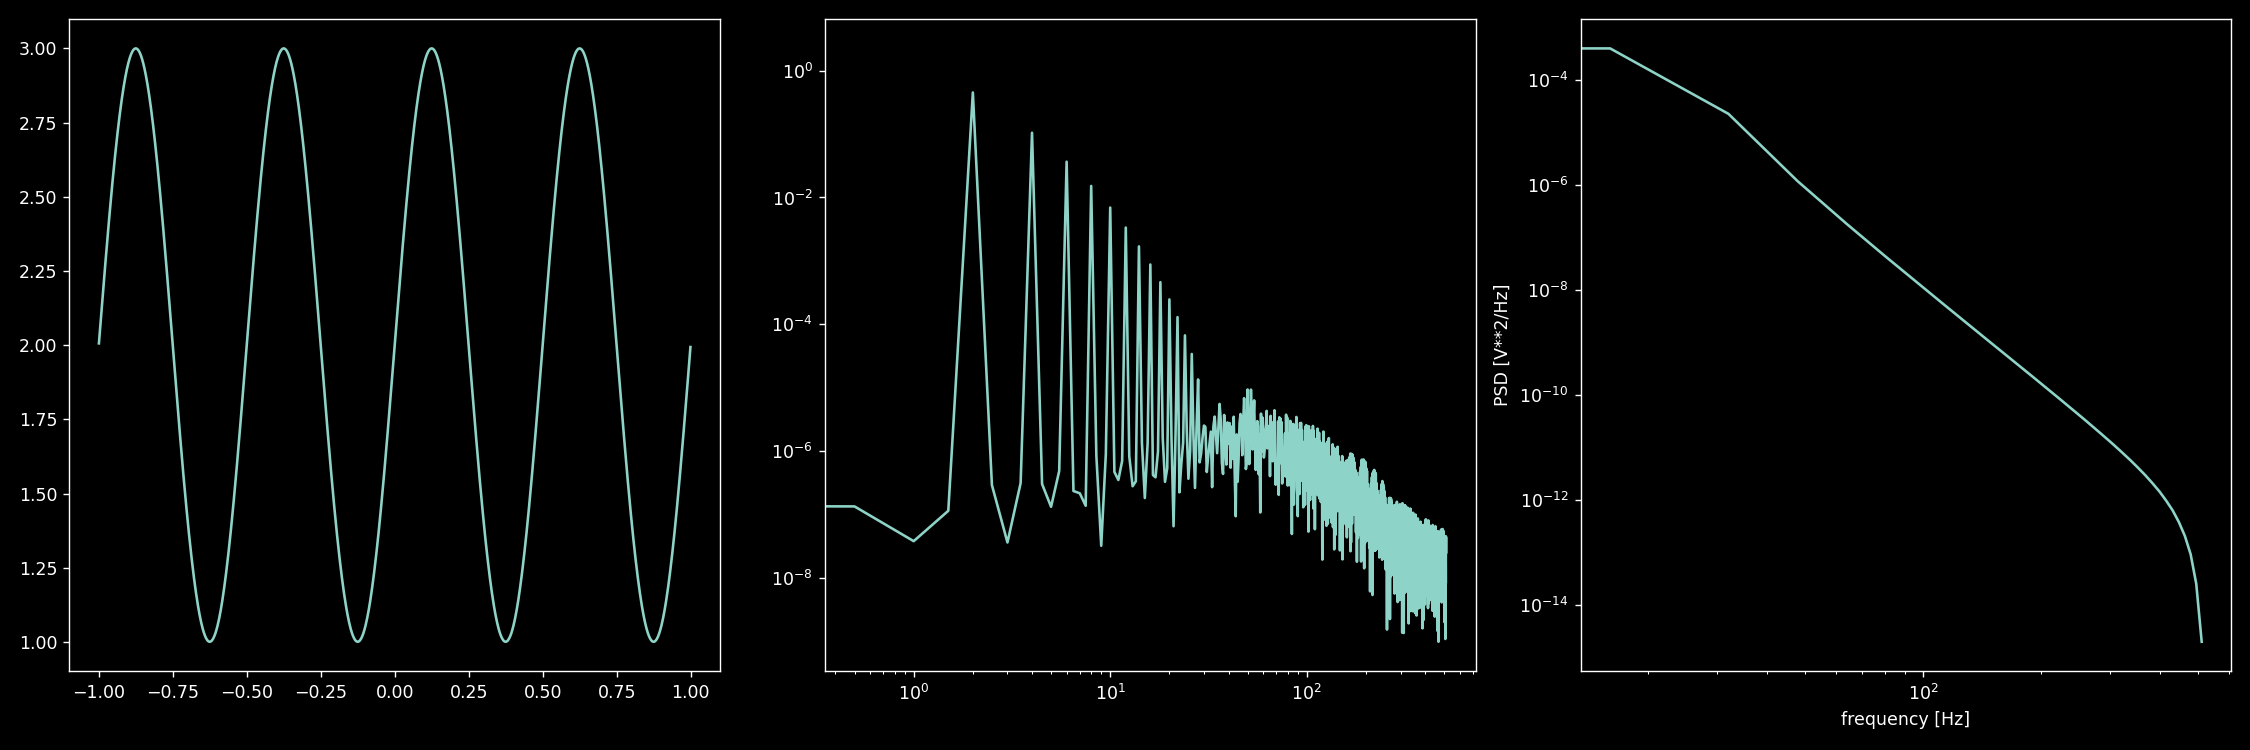

In [4]:
# sample the pdf using the inverse CFD, plotting shows the pdf
sampled = samplePDF(pdf, plot = False, numParticles = numParticles)
# sample positions according to the given pdf
fluidPositions = ((torch.tensor(sampled)/2 +0.5)* (maxDomain - minDomain) + minDomain).type(dtype).to(device)
# initially zero velocity everywhere
fluidVelocities = torch.zeros(fluidPositions.shape[0]).type(dtype).to(device)
# and all particles with identical masses
fluidAreas = torch.ones_like(fluidPositions) * baseArea
# simulationStates holds all timestep information
simulationStates = []
# plot initial density field to show starting conditions
density = plotDensityField(fluidPositions, fluidAreas, minDomain, maxDomain, particleSupport)

## Running the simulation based on an RK4 time integrator

In [5]:
# run the simulation using RK4
for i in tqdm(range(timesteps)):
    # Compute state for substep 1
    v1 = torch.clone(fluidVelocities)
    # RK4 substep 1
    dudt_k1, dxdt_k1, fluidDensity, fluidPressure = computeUpdate(fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, dt)   
    # Compute state for substep 2
    x_k1 = fluidPositions + 0.5 * dt * dxdt_k1
    x_k1[x_k1 < minDomain] += maxDomain - minDomain
    x_k1[x_k1 > maxDomain] -= maxDomain - minDomain    
    u_k1 = fluidVelocities + 0.5 * dt * dudt_k1    
    # RK4 substep 2
    dudt_k2, dxdt_k2, _, _ = computeUpdate(x_k1, u_k1, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, 0.5 * dt)    
    # Compute state for substep 2
    x_k2 = fluidPositions + 0.5 * dt * dxdt_k2
    x_k2[x_k2 < minDomain] += maxDomain - minDomain
    x_k2[x_k2 > maxDomain] -= maxDomain - minDomain
    u_k2 = fluidVelocities + 0.5 * dt * dudt_k2
    # RK4 substep 3
    dudt_k3, dxdt_k3, _, _ = computeUpdate(x_k2, u_k2, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport,  0.5 * dt)    
    # Compute state for substep 4    
    x_k3 = fluidPositions + dt * dxdt_k3
    x_k3[x_k3 < minDomain] += maxDomain - minDomain
    x_k3[x_k3 > maxDomain] -= maxDomain - minDomain
    u_k3 = fluidVelocities + dt * dudt_k3
    # RK4 substep 4
    dudt_k4, dxdt_k4, _, _ = computeUpdate(x_k3, u_k3, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, dt)    
    # RK substeps done, store current simulation state for later processing/learning. density and pressure are based on substep 1 (i.e., the starting point for this timestep)
    simulationStates.append(torch.stack([fluidPositions, fluidVelocities, fluidDensity, fluidPressure, dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4), dudt_k1, dudt_k2, dudt_k3, dudt_k4, fluidAreas]))
    # time integration using RK4 for velocity
#     fluidVelocities = fluidVelocities + dt * dudt_k1 # semi implicit euler mode
    fluidVelocities = fluidVelocities + dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4)
    fluidPositions = fluidPositions + dt * fluidVelocities
    # enforce periodic boundary conditions
    fluidPositions[fluidPositions < minDomain] += maxDomain - minDomain
    fluidPositions[fluidPositions > maxDomain] -= maxDomain - minDomain
# After the simulation has run we stack all the states into one large array for easier slicing and analysis
simulationStates = torch.stack(simulationStates)

  0%|          | 0/2048 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


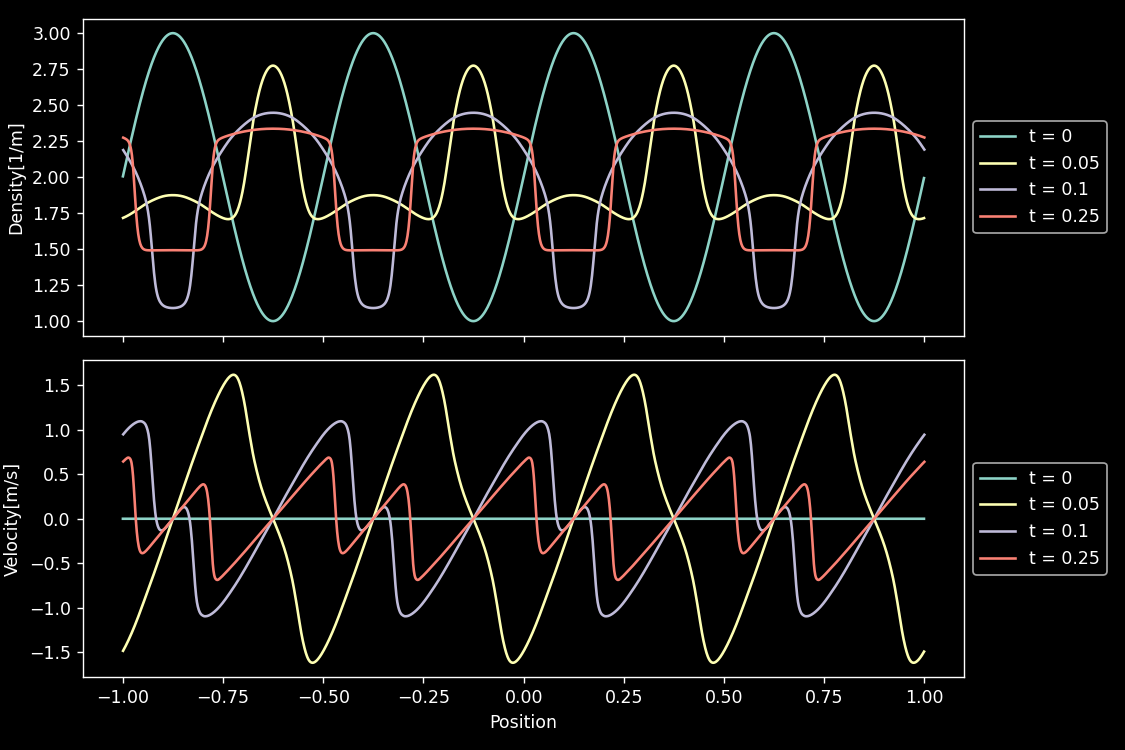

<IPython.core.display.Javascript object>


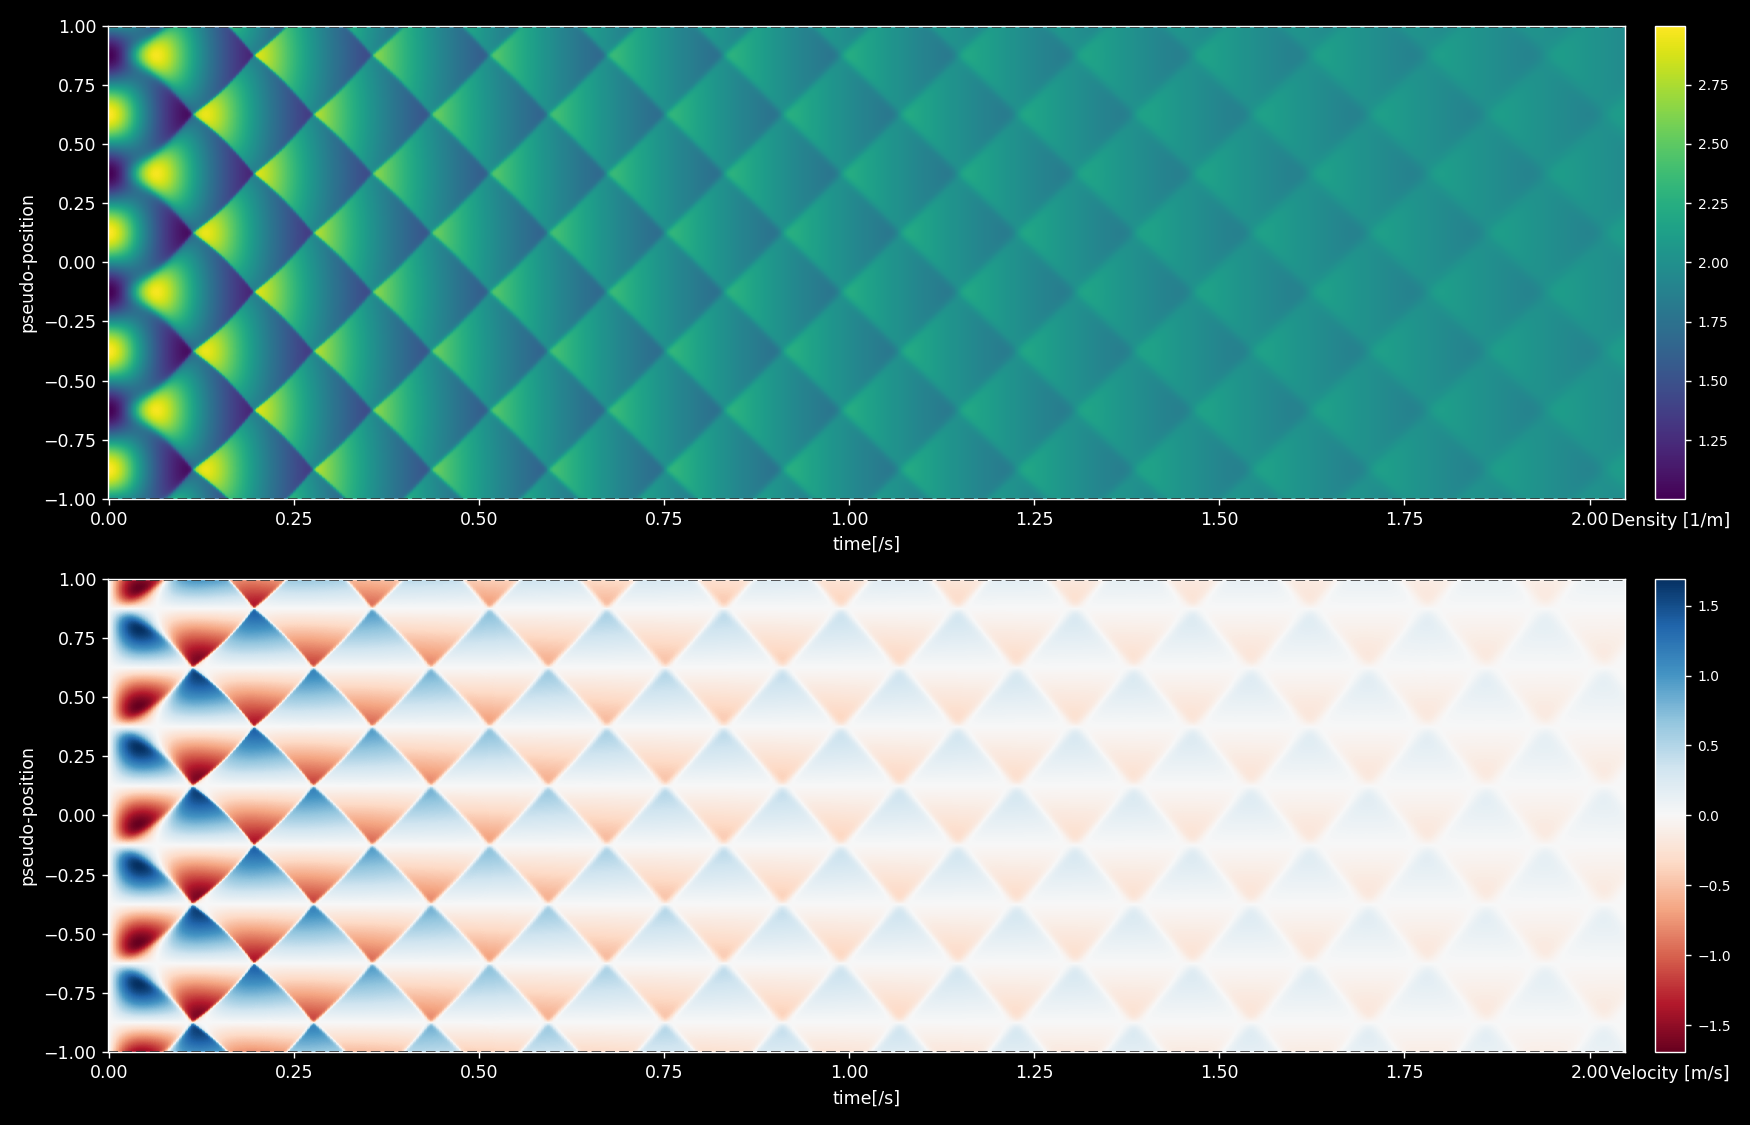

In [6]:
plotSimulationState(simulationStates, minDomain, maxDomain, dt, timepoints = [0, 50, 100, 250])
regularPlot(simulationStates, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps)

## Setup the Dataset and general functions for the NN

In [7]:
ignoredTimesteps = 256
batchSize = 4 # training batch size
# Training done on all timesteps except the last ignoredTimesteps
timestamps = np.arange(0,simulationStates.shape[0] - ignoredTimesteps)
testBatch = np.arange(len(simulationStates) - ignoredTimesteps, len(simulationStates))

# create pytorch dataloader (via pytorch geometric for convenience)
dataLoader = DataLoader(timestamps, shuffle=True, batch_size = batchSize).batch_sampler
dataIter = iter(dataLoader)

def getGroundTruth(bdata, stacked, simulationStates):
    gt = [simulationStates[i,2,:] for i in bdata] # Learning Density
    groundTruth = torch.hstack(gt)[:,None]
    return groundTruth
def getFeatures(stackedPositions, stackedAreas, stackedVelocities, stackedUpdates):
    features = torch.ones_like(stackedAreas)    
    return features   
def lossFunction(prediction, groundTruth):
    return (prediction - groundTruth)**2 # MSE

## Setup Hyperparameters and then initialize the NN modl

In [8]:
# Hyperparameters for the NN
lr = 1e-1 # Learning rate
iterations = 1000 # update iterations per epoch
epochs = 5 # total number of epochs, LR is halved every epoch
n = 15 # number of weights per continuous convolution
basis = 'linear' # basis for the convolution, set to linear for CConv
computeBatchSize = 128 # higher number = faster processing but more memory consumption (not relevant for small simulations)
windowFn = getWindowFunction('Wendland2_1D') # window function that is applied after each network layer
windowFn = None # set to None for now
normalized = False # rbf normalization, can be safely ignored

<IPython.core.display.Javascript object>


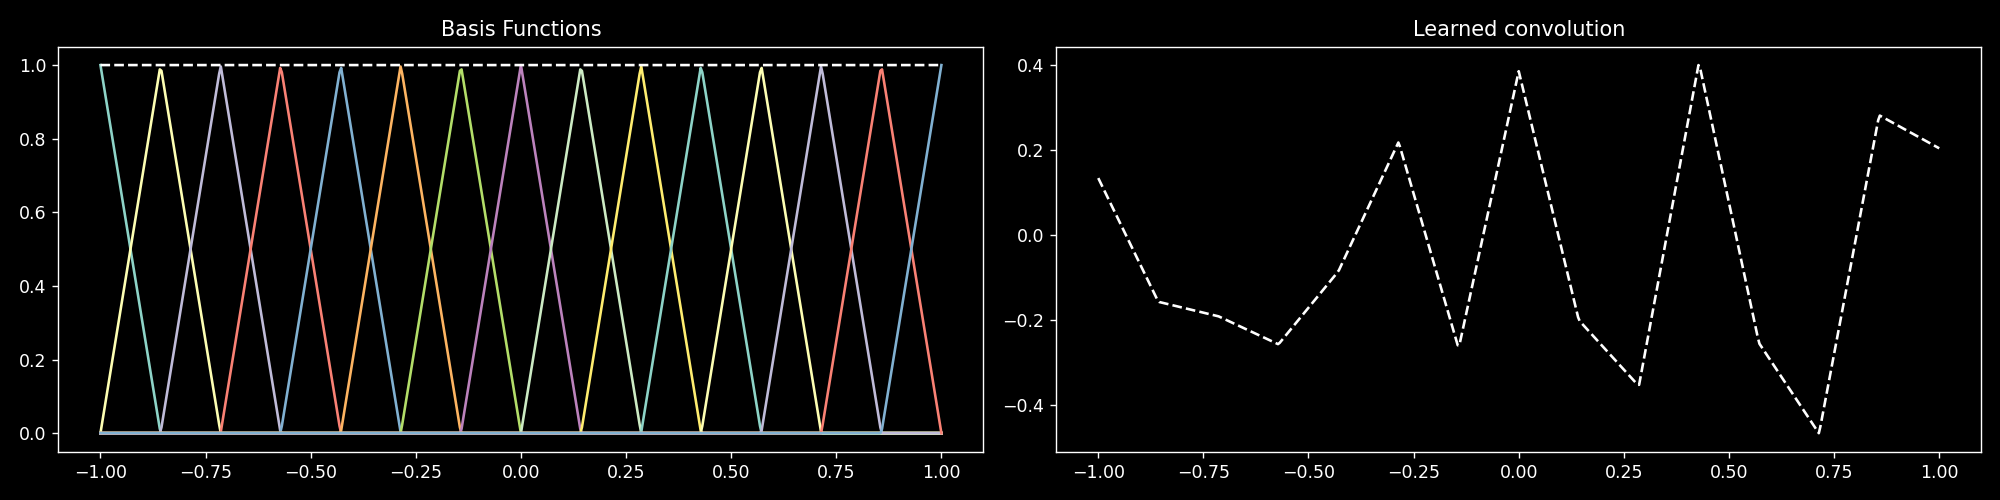

In [9]:
# Setup a single layer using the rbf convolution (which is a generalized CConv)
model = RbfConv(
            in_channels = 1, out_channels = 1,
                dim = 1, size = [n],
                rbf = basis,
                bias = True,
                linearLayer = False, biasOffset = False, feedThrough = False,
                preActivation = None, postActivation = None,
                coordinateMapping = 'cartesian',
                batch_size = [computeBatchSize, computeBatchSize], windowFn = windowFn, normalizeWeights = False, normalizeInterpolation = normalized).to(device)
# Adjusting the weight initialization for testing out things, defaults to uniform -0.05 to 0.05 as per the CConv paper
# torch.nn.init.uniform_(model.weight,0.0,0.3)
torch.nn.init.uniform_(model.weight,-.50,.50)
# Create optimizer for the single layer
optimizer = Adam(model.parameters(), lr=lr, weight_decay=0)
weightFn = lambda x: np.exp(-(x * 2.5)**2)
weightFn = getWindowFunction('Wendland2_1D')
# with torch.no_grad():    
#     model.weight[:,0,0] = torch.tensor(weightFn(np.linspace(-1,1,n)))
#     model.weight[:,0,0] = kernel(torch.abs(torch.linspace(-1,1,n)),1) * baseArea / particleSupport
plotWeights({k: v.cpu() for k, v in model.state_dict().items()}, basis, normalized)
# count_parameters(model)

# plotRandomWeights(32, n, basis, 'Wendland2_1D')

## Training and Evaluation

In [10]:
# create progress bar and arrays to hold the learning progress
pb = tqdm(range(epochs * iterations))
lossArray = []
batches = []
weights = []
testing = []
# the actual learning process
for epoch in range(epochs):
    losses = []
    b, l, w = processDataLoaderIter(pb, iterations, epoch, lr, \
                                    dataLoader, dataIter, batchSize, model, optimizer, \
                                    simulationStates, minDomain, maxDomain, particleSupport, \
                                    lossFunction, getFeatures, getGroundTruth, None,\
                                    train = True, prefix = '', augmentAngle = False, augmentJitter = False, jitterAmount = 0.01)
    lossArray.append(l)
    batches.append(b)
    weights.append(w)
    if True: #epoch % 1 == 0 and epoch > 0:
        lr = lr * 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


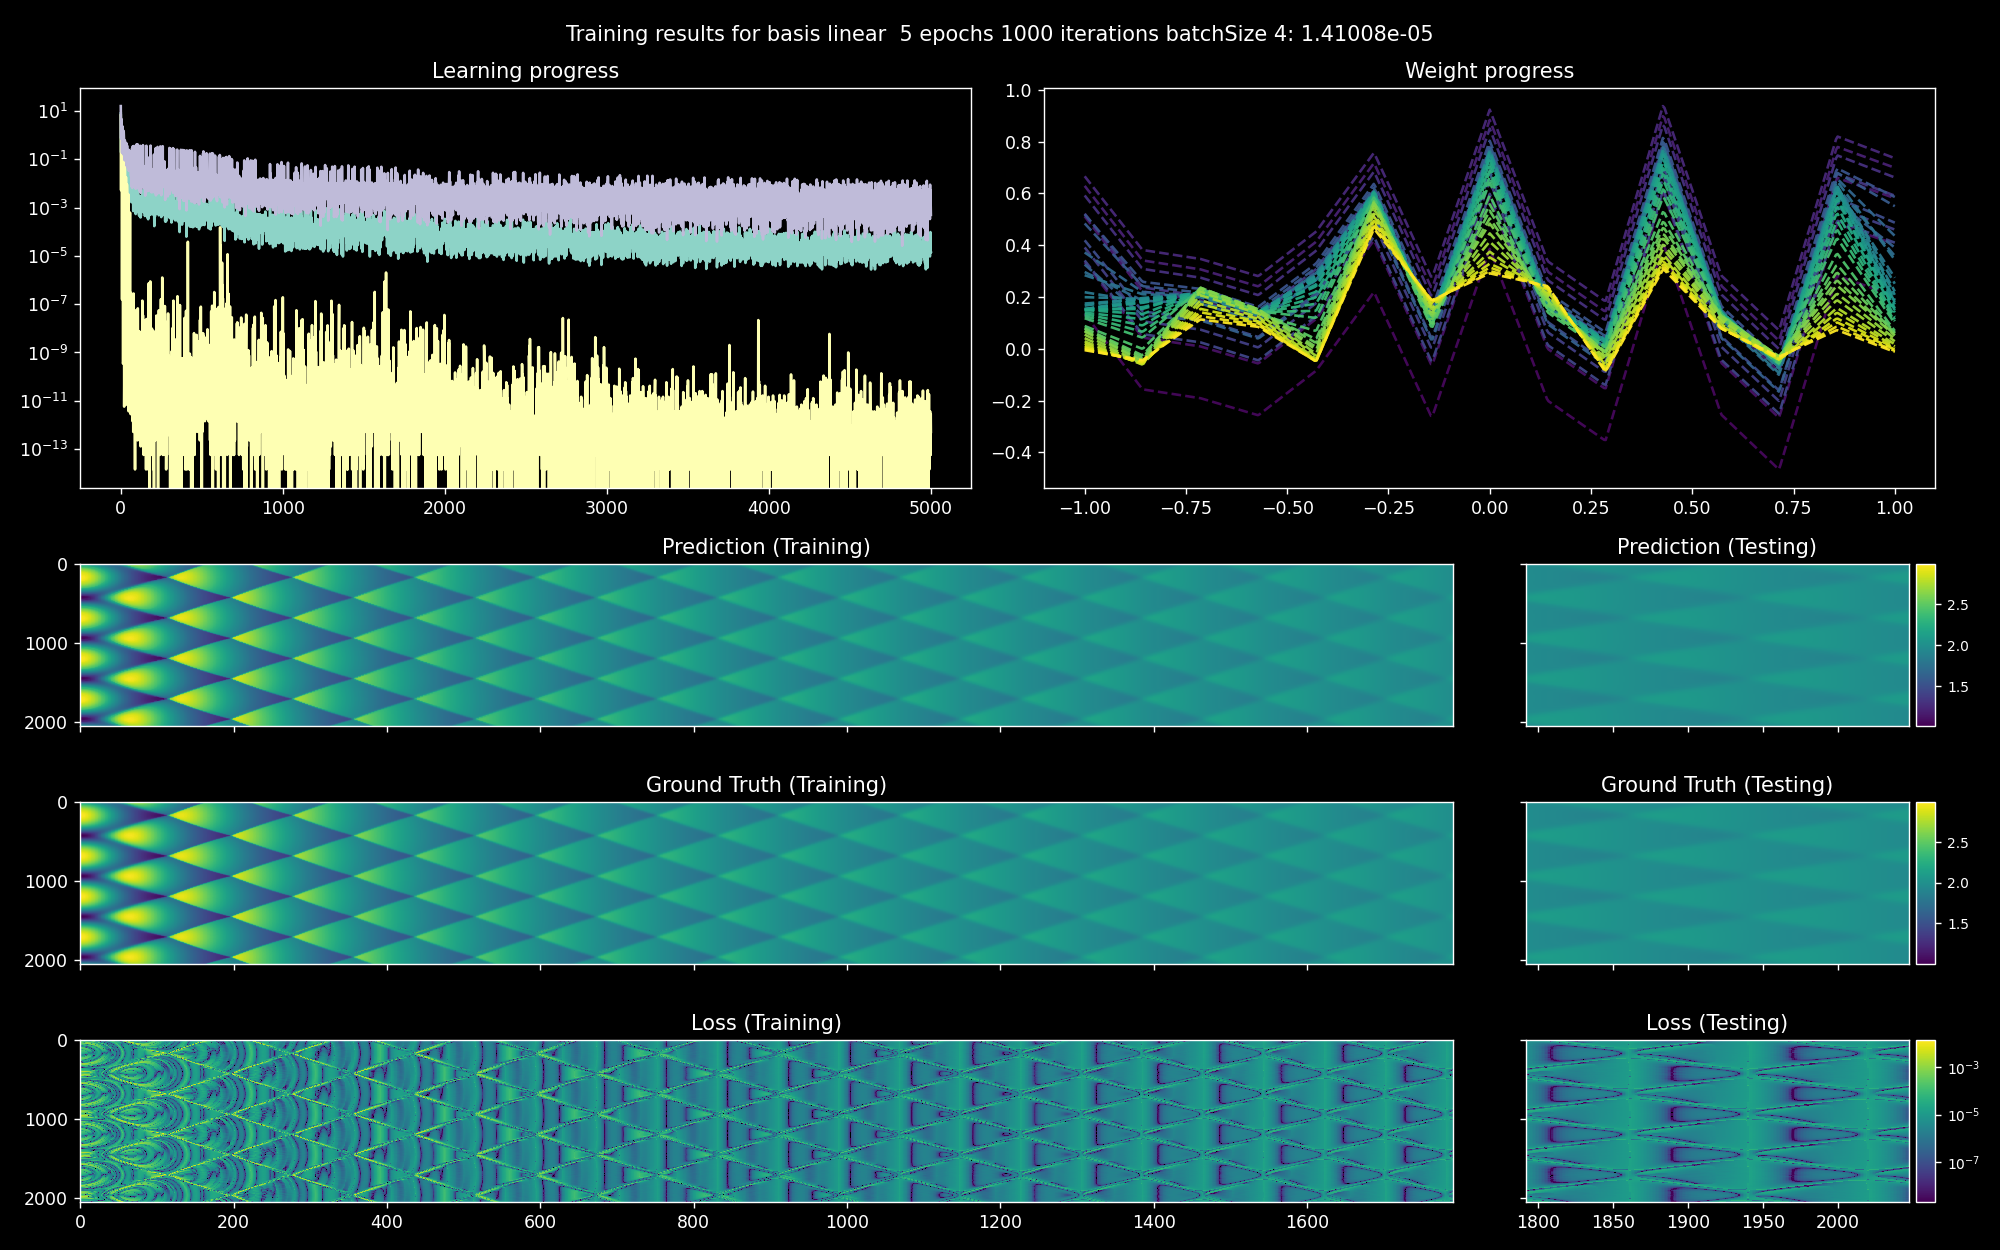

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
fig, axis = plotAll(model, device, weights, basis, normalized, iterations, epochs, numParticles, batchSize, lossArray, simulationStates, minDomain, maxDomain, particleSupport, timestamps, testBatch, lossFunction, getFeatures, getGroundTruth, None)

## Setting up a new simulation

<IPython.core.display.Javascript object>


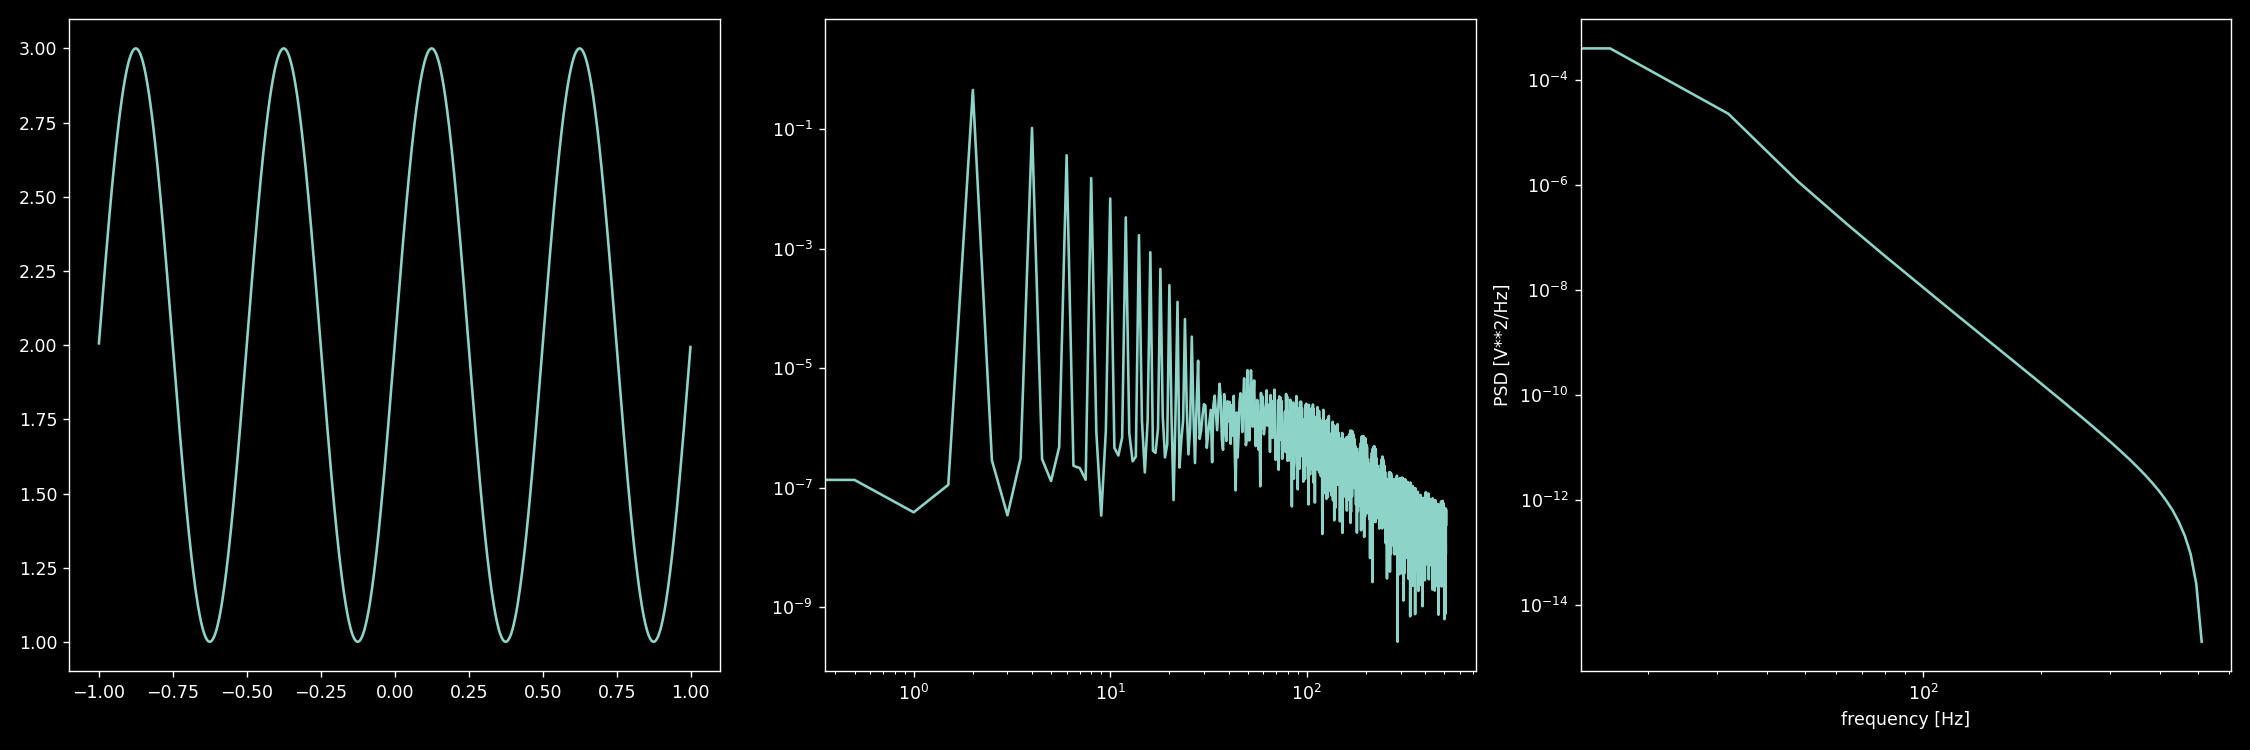

In [12]:
# sample the pdf using the inverse CFD, plotting shows the pdf
sampled = samplePDF(pdf, plot = False, numParticles = numParticles)
# sample positions according to the given pdf
fluidPositions = ((torch.tensor(sampled)/2 +0.5)* (maxDomain - minDomain) + minDomain).type(dtype).to(device)
# initially zero velocity everywhere
fluidVelocities = torch.zeros(fluidPositions.shape[0]).type(dtype).to(device)
# and all particles with identical masses
fluidAreas = torch.ones_like(fluidPositions) * baseArea
# simulationStates holds all timestep information
simulationStatesML = []
# plot initial density field to show starting conditions
density = plotDensityField(fluidPositions, fluidAreas, minDomain, maxDomain, particleSupport)

## Including the NN into the simulation step:

In [13]:
def prepareNetwork(fluidPositions, fluidAreas, fluidVelocities, minDomain, maxDomain, particleSupport, getFeatures):
    ghosts = createGhostParticles(fluidPositions, minDomain, maxDomain) 
    # perform neighborhood search for batch and split the data into 3 separate lists
    neighborInformation = findNeighborhoods(fluidPositions, ghosts, particleSupport) 
    neighbors = neighborInformation[0]
    radialDistances = neighborInformation[1]
    distances = neighborInformation[2]
    # compute the density on the given batch data
    ones = torch.ones_like(fluidAreas)
    # compute the signed distances needed for the network layer, uses the radialDistances and directions computed before                
    d = radialDistances[:,None] * torch.sign(distances[:,None])  
    
    return fluidPositions, getFeatures(fluidPositions, fluidAreas, fluidVelocities, None), neighbors, d

# SPH simulation step, returns dudt, dxdt as well as current density and pressure
def computeUpdateML(model, fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphCoefficient, particleSupport, dt):
    #  1. Create ghost particles for our boundary conditions
    ghostPositions = createGhostParticles(fluidPositions, minDomain, maxDomain)
    #  2. Find neighborhoods of all particles:
    fluidNeighbors, fluidRadialDistances, fluidDistances = findNeighborhoods(fluidPositions, ghostPositions, particleSupport)
    
    stackedPositions, features, stackedNeighbors, d = prepareNetwork(fluidPositions, fluidAreas, fluidVelocities, minDomain, maxDomain, particleSupport, getFeatures)
    with torch.no_grad():
        fluidDensity = model((features[:,None], features[:,None]), stackedNeighbors, d)[:,0]
#     print(fluidDensity)
    #  3. Compute \rho using an SPH interpolation
#     model()
    
#     model((features[:,None], features[:,None]), stackedNeighbors, d)
    
#     fluidDensity = computeDensity(fluidPositions, fluidAreas, particleSupport, fluidRadialDistances, fluidNeighbors)
    #  4. Compute the pressure of each particle using an ideal gas EOS
    fluidPressure = (fluidDensity - 1.0) * kappa * restDensity
    #  5. Compute the XSPH term and apply it to the particle velocities:    
    xsphUpdate = computeXSPH(fluidPositions, fluidVelocities, fluidDensity, fluidAreas, particleSupport, xsphCoefficient, fluidNeighbors, fluidRadialDistances)
    #  6. Compute pressure forces and resulting acceleration
    fluidPressureForces = computePressureForces(fluidPositions, fluidDensity, fluidPressure, fluidAreas, particleSupport, restDensity, fluidNeighbors, fluidRadialDistances, fluidDistances)
    fluidAccel = fluidPressureForces # / (fluidAreas * restDensity)
    # 7. Compute kinematic viscosity
    laminarViscosity = computeDiffusion(fluidPositions, fluidVelocities, fluidAreas, fluidDensity, particleSupport, restDensity, diffusionAlpha, diffusionBeta, c0, fluidNeighbors, fluidRadialDistances, fluidDistances) # currently broken for some reason
#     fluidAccel += laminarViscosity
    fluidAccel += xsphUpdate / dt + laminarViscosity
    return fluidAccel, fluidVelocities, fluidDensity, fluidPressure

## And run the hybrid simulation

In [14]:
# run the simulation using RK4
for i in tqdm(range(timesteps)):
    # Compute state for substep 1
    v1 = torch.clone(fluidVelocities)
    # RK4 substep 1
    dudt_k1, dxdt_k1, fluidDensity, fluidPressure = computeUpdateML(model, fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, dt)   
    # Compute state for substep 2
    x_k1 = fluidPositions + 0.5 * dt * dxdt_k1
    x_k1[x_k1 < minDomain] += maxDomain - minDomain
    x_k1[x_k1 > maxDomain] -= maxDomain - minDomain    
    u_k1 = fluidVelocities + 0.5 * dt * dudt_k1    
    # RK4 substep 2
    dudt_k2, dxdt_k2, _, _ = computeUpdateML(model, x_k1, u_k1, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, 0.5 * dt)    
    # Compute state for substep 2
    x_k2 = fluidPositions + 0.5 * dt * dxdt_k2
    x_k2[x_k2 < minDomain] += maxDomain - minDomain
    x_k2[x_k2 > maxDomain] -= maxDomain - minDomain
    u_k2 = fluidVelocities + 0.5 * dt * dudt_k2
    # RK4 substep 3
    dudt_k3, dxdt_k3, _, _ = computeUpdateML(model, x_k2, u_k2, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport,  0.5 * dt)    
    # Compute state for substep 4    
    x_k3 = fluidPositions + dt * dxdt_k3
    x_k3[x_k3 < minDomain] += maxDomain - minDomain
    x_k3[x_k3 > maxDomain] -= maxDomain - minDomain
    u_k3 = fluidVelocities + dt * dudt_k3
    # RK4 substep 4
    dudt_k4, dxdt_k4, _, _ = computeUpdateML(model, x_k3, u_k3, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, dt)    
    # RK substeps done, store current simulation state for later processing/learning. density and pressure are based on substep 1 (i.e., the starting point for this timestep)
    simulationStatesML.append(torch.stack([fluidPositions, fluidVelocities, fluidDensity, fluidPressure, dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4), dudt_k1, dudt_k2, dudt_k3, dudt_k4, fluidAreas]))
    # time integration using RK4 for velocity
#     fluidVelocities = fluidVelocities + dt * dudt_k1
    fluidVelocities = fluidVelocities + dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4)
    fluidPositions = fluidPositions + dt * fluidVelocities
    # enforce periodic boundary conditions
    fluidPositions[fluidPositions < minDomain] += maxDomain - minDomain
    fluidPositions[fluidPositions > maxDomain] -= maxDomain - minDomain
# After the simulation has run we stack all the states into one large array for easier slicing and analysis
simulationStatesML = torch.stack(simulationStatesML)


  0%|          | 0/2048 [00:00<?, ?it/s]

## Finally visualize the results

<IPython.core.display.Javascript object>


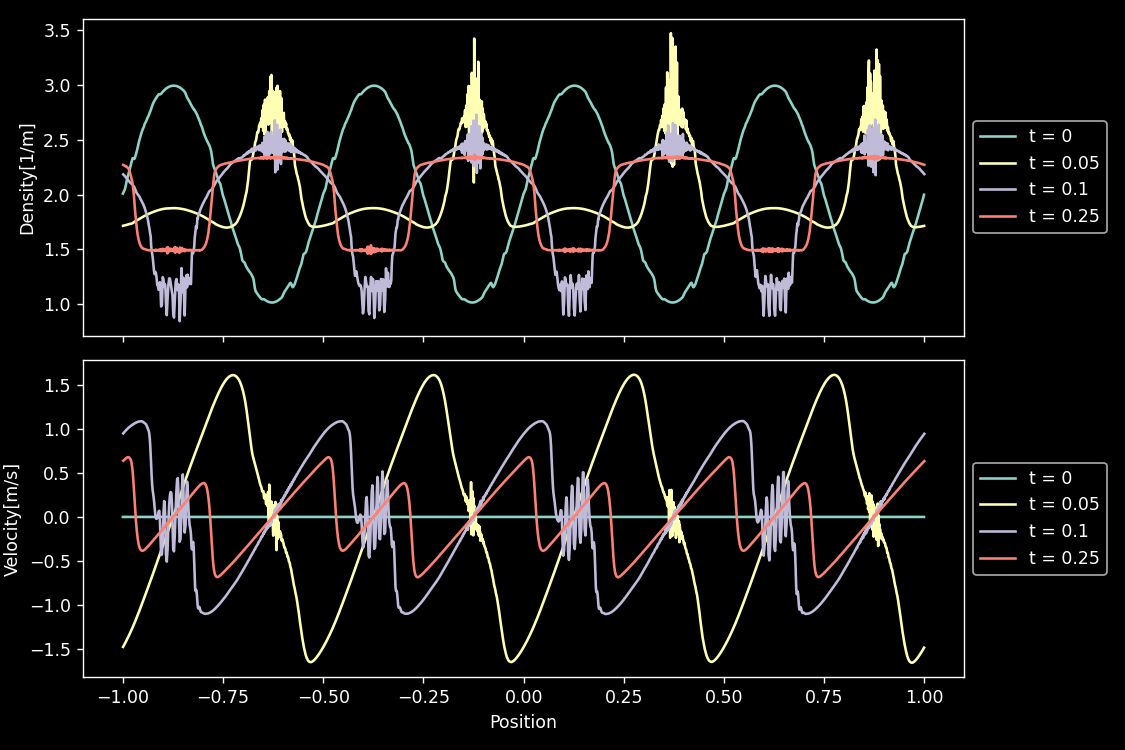

In [15]:
plotSimulationState(simulationStatesML, minDomain, maxDomain, dt, timepoints = [0, 50, 100, 250])

<IPython.core.display.Javascript object>


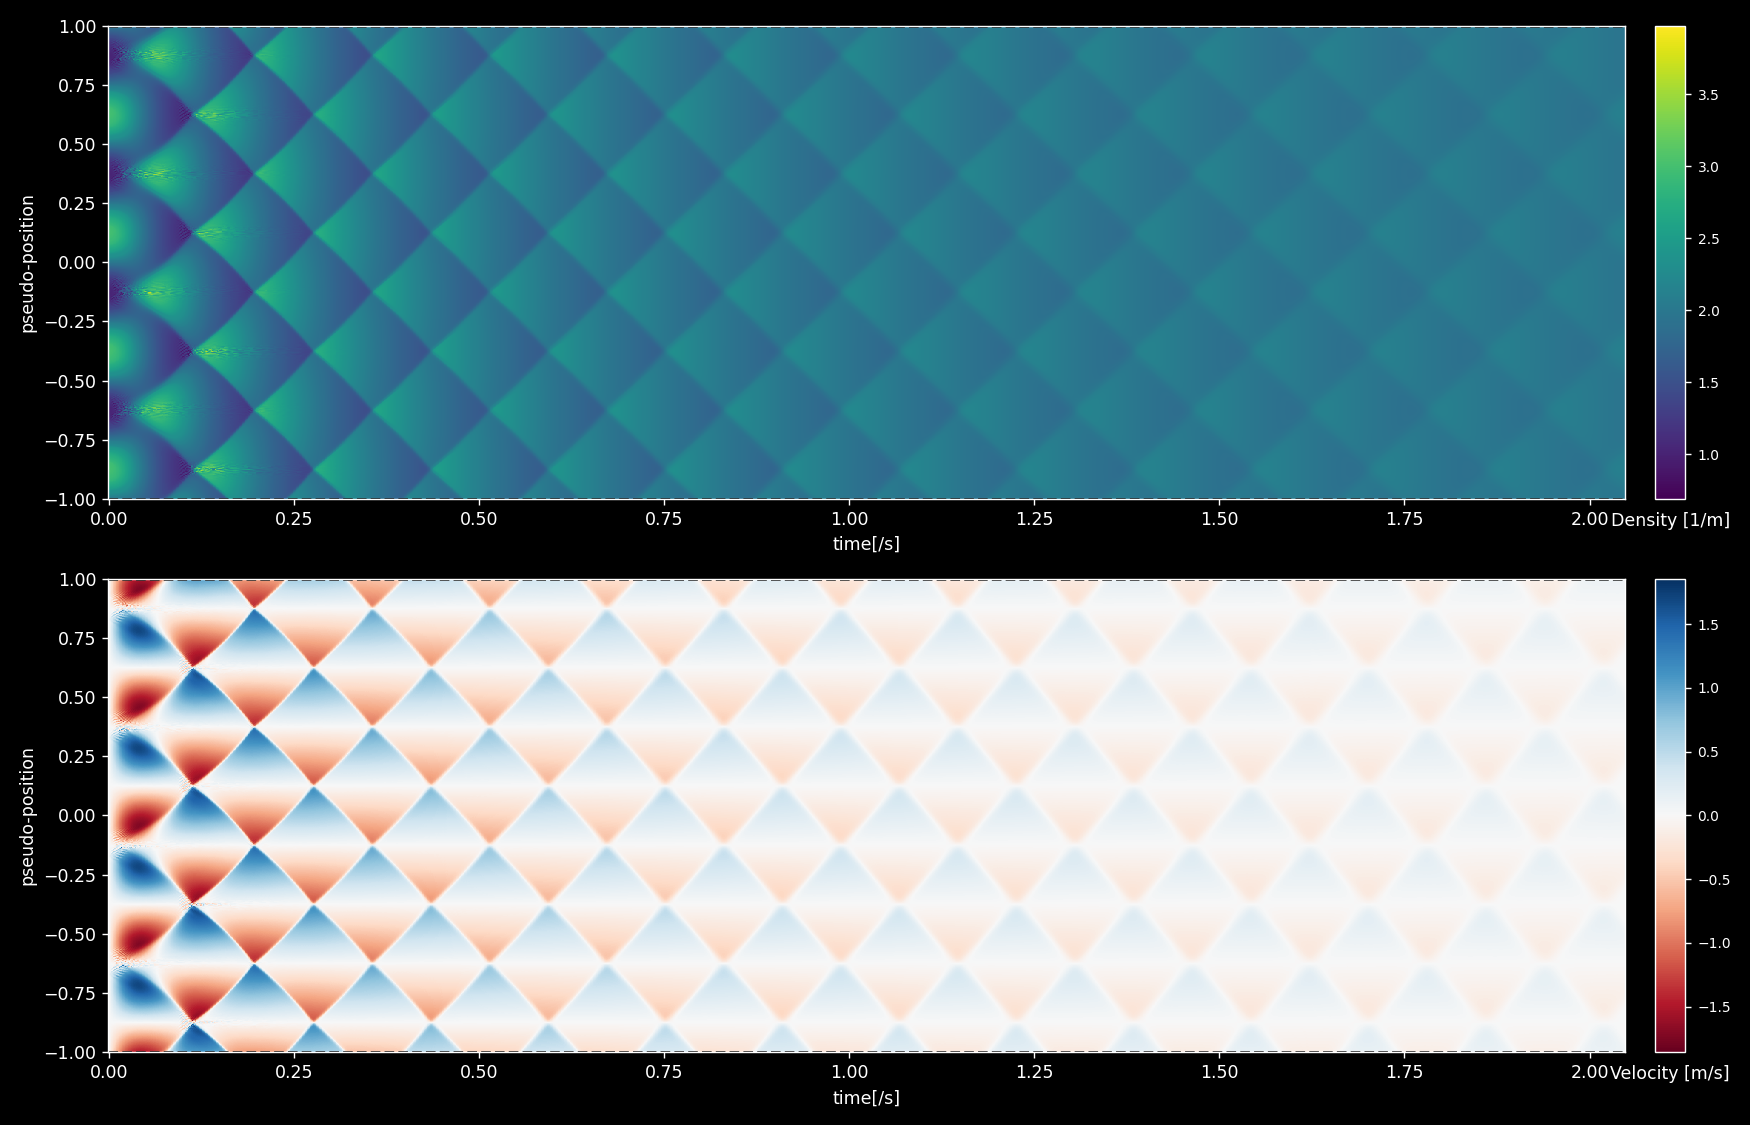

In [16]:
regularPlot(simulationStatesML, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps)

<IPython.core.display.Javascript object>


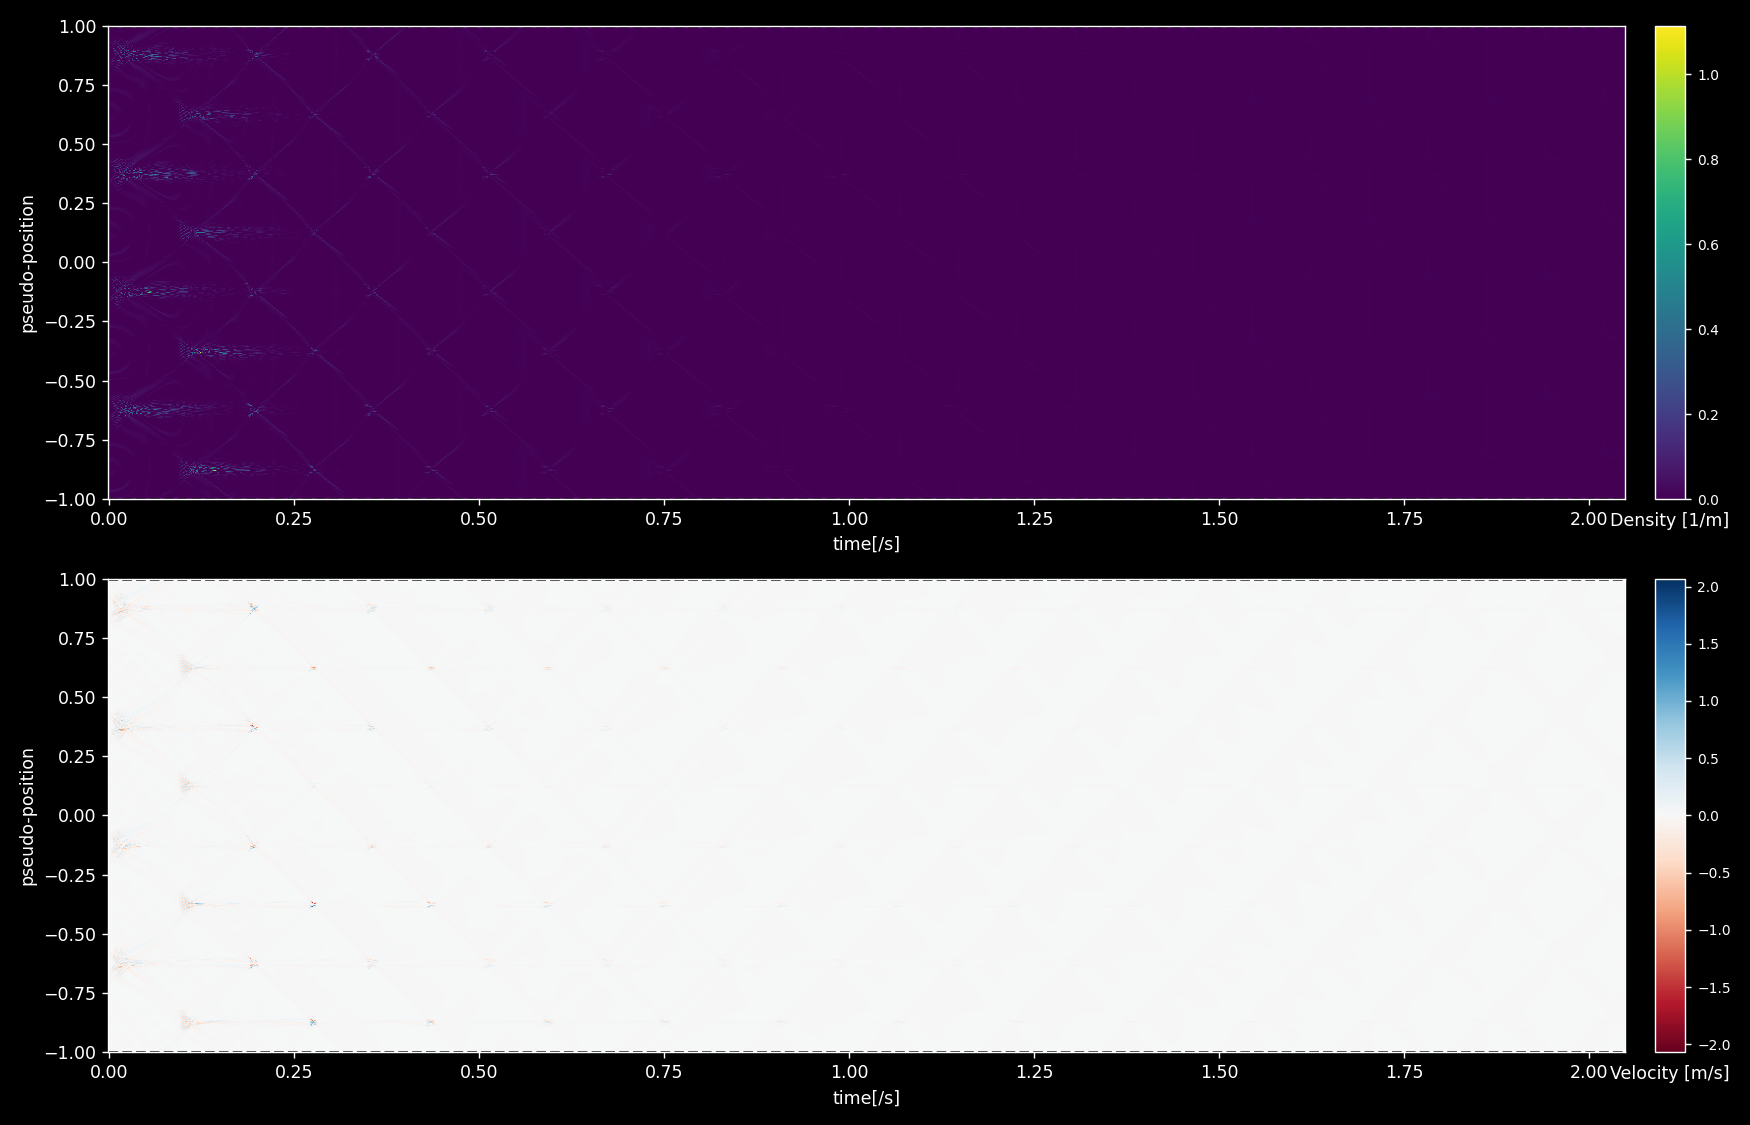

In [17]:
simulationStatesDiff = simulationStates - simulationStatesML
simulationStatesDiff[:,0] = simulationStates[:,0]

regularPlot(simulationStatesDiff, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps)